In [6]:
import numpy as np
from scipy.linalg import svdvals
from matplotlib import pyplot as plt
import time

In [24]:
m = 40
n = 100

We first set up the problem
\begin{align*}
    Ax = b
\end{align*}
where we $A$ is a random, standard Gaussian matrix of dimension $m \times n$ (where the actual size of $m,n$ are defined in the cell immediately above), the true $x$ has 10 randomly selected spikes, and $b$ is given by
\begin{align*}
    b = Ax + \gamma y
\end{align*}
where $y$ is a standard Gaussian noise vector.

In [29]:
gamma = 0.05
A = np.random.normal(0,1,(m,n))
x_true = np.zeros(n)
idx_spike = np.random.randint(0,n,10)
x_true[idx_spike] = 1
b = np.dot(A,x_true) + gamma*np.random.normal(0,1,m)

Here we initialize a first "guess" for $x$.

In [27]:
x_init = np.ones(n)

Now we want to find a potential answer to our inverse problem and solve for some $x$. To do this, we first calculate the $\lambda$ hyperparameter used in the regularized linear least squares problem:
\begin{align*}
     \displaystyle \min_{x} \frac{1}{2}||Ax - b||^{2} + \lambda R(Cx).
\end{align*}
Since we are first implementing the lasso method, we know necessarily that $R(Cx) = ||x||_1$.

In [30]:
lam = np.linalg.norm(np.dot(A.T, b),ord=np.inf)/10

First, we are going to implement the Lasso method. Since Lasso necessarily uses the $||\cdot ||_1$ norm, then we define 
\begin{align}
    \mathrm{prox}_{\lambda || \cdot ||_1}(x) = \mathrm{sign}(x)\mathrm{max}(|x|-\lambda,0)
\end{align}
Note, it is necessary that $x \in \mathbb{R}$.

Here we create a maximum function that compares every element in a $\verb+numpy+$ array to a desired number (of type float or int) and returns a vector of like dimension that has taken the maximum value between the desired number and every element in the array.

In [31]:
def max_function(x, num_compare):
    return np.array([i if i >= num_compare else num_compare for i in x])

This function implements formula (1). Note that every operation is completed entry-wise.

In [32]:
def prox_op(x,lambd):
    return np.sign(x)*max_function(np.abs(x)-lambd,0)

In [33]:
cond_A = svdvals(A)[0]
eta = 0.001
k = 0
tol = 0.00001
max_step = 100
assert eta <= 1/(cond_A**2)

We now create a $\verb+lasso+$ function that will perform the desired prox-gradient descent and solve the inverse problem constructed, with the intent of creating an $\verb+x_guess+$ vector that is as close to $\verb+x_true+$ as possible.

In [34]:
def lasso(x, max_step, k, eta, lam, tol):
    start = time.time()
    while (max_step > tol):
        k += 1
        x_old = x
        x = prox_op(x_old - eta*(A.T)@((A@x_old)-b),eta*lam)
        step = abs((x - x_old)/eta)
        max_step = step.max()
    end = time.time()
    return x, start, end, k

Now we are going to run our $\verb+lasso+$ function and see if, at the very least, it includes the nonzero entries inside our $\verb+x_true+$ vector.

In [35]:
x_guess, start, end, iters = lasso(x_init, max_step, k, eta, lam, tol)

In [37]:
x_guess_nonzero = np.nonzero(x_guess)
x_true_nonzero = np.nonzero(x_true)

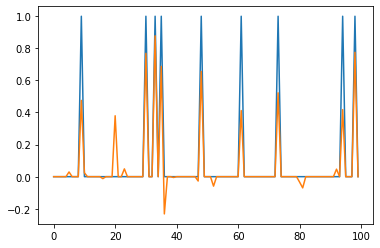

In [39]:
from matplotlib import pyplot as plt
plt.plot(x_true)
plt.plot(x_guess)

In [40]:
np.isin(x_true_nonzero, x_guess_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True]])

From what is directly above, we see clearly that all the nonzero entries inside our true solution $\verb+x_true+$ are at least inside the solution given by the lasso regression, $\verb+x_guess+$. Though, note that the number of nonzero entries in $\verb+x_guess+$ is greater than that of $\verb+x_true+$:

In [41]:
print("This is the number of nonzero entries in x_guess: " + str(len(x_guess_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in x_guess: 21
This is the number of nonzero entries in x_true: 9


Hence, there is imprecision in that we would prefer to have more entries in $\verb+x_guess+$ to be closer to 0.

We also show the number of iterations and the time it takes for the lasso method to converge:

In [42]:
print("This is the number of iterations required for lasso to converge: " + str(iters))
print("This is the number of seconds it takes for lasso to converge: " + str(end - start))

This is the number of iterations required for lasso to converge: 5966
This is the number of seconds it takes for lasso to converge: 0.31332826614379883


We will compare the above to the SR3 method. For reference, the general SR3 formulation is as follows:
\begin{align*}
    \displaystyle \min_{x,w} \frac{1}{2}||Ax-b||^{2} + \lambda R(w) + \frac{\kappa}{2}||Cx - w||^{2}.
\end{align*}
We first want to recover a relaxed version of lasso. To do this, we take $R(\cdot) = ||\cdot ||_{1}$ and $C=I$. In this instance as well, we take $\kappa = 100$. We proceed as follows. 

In [83]:
C = np.eye(n,n)
kappa = 0.1
lam_sr3 = (lam/(1 + cond_A**2))*kappa

Central to the algorithm we implement is
\begin{align*}
    H_{\kappa} = A^{\top}A + \kappa C^{\top}C .
\end{align*}
We define this matrix immediately below.

In [84]:
H_k = np.dot(A.T,A) + kappa*np.dot(C.T,C)
H = np.linalg.inv(H_k)
w = np.ones(n)

We now implement the algorithm for SR3

In [85]:
k_sr3 = 0
eta = 1/kappa
max_step = 100

In [86]:
def sr3(w, H, A, b, C, max_step, k, eta, tol, kappa, lam):
    start = time.time()
    while (max_step > tol):
        k += 1
        w_old = w
        x = H@(np.dot(A.T, b) + kappa*np.dot(C.T, w_old))
        w = prox_op(np.dot(C,x),eta*lam)
        step = abs((w - w_old)/eta)
        max_step = step.max()
    end = time.time()
    return w, start, end, k

In [87]:
w_guess, start_sr3, end_sr3, iters_sr3 = sr3(w,H,A,b,C,max_step,k_sr3,eta,tol,kappa,lam_sr3)

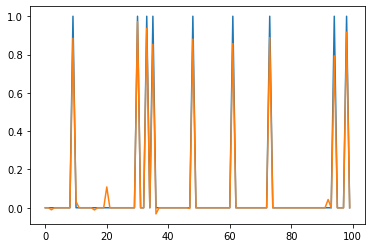

In [88]:
plt.plot(x_true)
plt.plot(w_guess)

In [89]:
w_guess_nonzero = np.nonzero(w_guess)
np.isin(x_true_nonzero, w_guess_nonzero)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True]])

Clearly, $\verb+w_guess+$ contains nonzero entries in mostly the same places as does $\verb+x_true+$. Next, we look at how many nonzero entries there are in $\verb+w_guess+$.

In [90]:
print("This is the number of nonzero entries in w_guess: " + str(len(w_guess_nonzero[0])))
print("This is the number of nonzero entries in x_true: " + str(len(x_true_nonzero[0])))

This is the number of nonzero entries in w_guess: 16
This is the number of nonzero entries in x_true: 9


Note that, even though there are more nonzero entries in $\verb+w_guess+$ than in $\verb+x_true+$, the number of non-sparse entries is much closer than what was obtained using the standard lasso method, using all the same parameters. Thus, we have a higher level of precision, as we desired.

Last, we look at the number of iterations SR3 took to converge and the number of seconds required fro convergence.

In [91]:
print("This is the number of iterations required for SR3 to converge: " + str(iters_sr3))
print("This is the number of seconds it takes for SR3 to converge: " + str(end_sr3 - start_sr3))

This is the number of iterations required for SR3 to converge: 254
This is the number of seconds it takes for SR3 to converge: 0.03615593910217285


Note that, even for a small-dimension problem, the number of iterations required for SR3 to converge is decreased by an order of 10, as for the number of seconds required for convergence. This is exactly what we anticipated from the results shown in J33.

Use relationship between condition number of $A^{\top}A$ to get $\lambda$ parameter value for relaxed problem. It's how I define it using the variable $\verb+lam_sr3+$.

Next, we seek to deblur an image using SR3, implementing the FISTA algorithm.

In [2]:
import pywt
import pywt.data

In [3]:
original = pywt.data.camera()

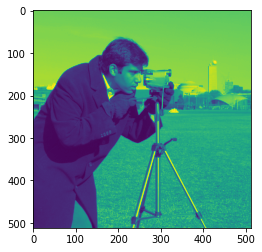

In [7]:
plt.imshow(original)

In [10]:
coeffs2 = pywt.dwt2(original, 'bior1.3')

In [14]:
coeffs2[0].shape

(258, 258)

In [17]:
coeffs2[1][0].shape

(258, 258)

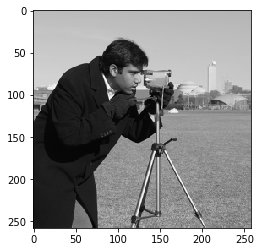

In [19]:
plt.imshow(coeffs2[0],interpolation="nearest", cmap=plt.cm.gray)

In [20]:
m=512
n=512

In [21]:
A = np.random.normal(0,1,(m,n))

In [23]:
pywt.idwt(A,'db2')

TypeError: idwt() missing 1 required positional argument: 'wavelet'

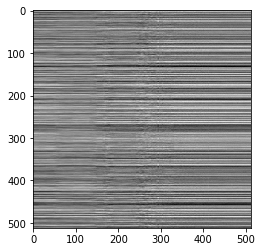

In [25]:
blurred = np.dot(A,original)
plt.imshow(blurred,interpolation="nearest", cmap=plt.cm.gray)